# Reinforced learning for CartPole problem from Open AI Gym environment. 

From gym.openai.com site:

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Neural network is used to estimate Q-value function. It is trained with epsilon-greedy policy and using a memory buffer. 

![cart_pole.png](cart_pole.png)


In [26]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt



def create_model(state_size,action_size):
    targetNN=Sequential()
    targetNN.add(Dense(24, input_shape=(state_size,), activation="relu"))
    targetNN.add(Dense(24, activation="relu"))
    targetNN.add(Dense(12, activation="relu"))
    targetNN.add(Dense(action_size, activation="linear"))
    targetNN.compile(loss="mse", optimizer=Adam())
    return targetNN

class deep_Q_learning():
    def __init__(self, episodes, max_memory_size, discount, epsilon_start,epsilon_min,epsilon_decay,
                batch_size, state_size,action_size):
        self.episodes=episodes
        self.memory=deque(maxlen=max_memory_size)
        self.discount=discount
        self.epsilon=epsilon_start
        self.epsilon_min=epsilon_min
        self.epsilon_decay=epsilon_decay
        self.batch_size=batch_size
        self.rewards=[]
        self.model=create_model(state_size,action_size)
        self.state_size=state_size
        self.action_size=action_size
        
    def add_to_memory(self,state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def decrease_epsilon(self):
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay
            
    def forward_step(self,state):
        if np.random.random() <= self.epsilon:
            action=random.randrange(2)
        else:
            action=np.argmax(self.model.predict(state))
        return action
    
    def get_memory_size(self):
        return len(self.memory)
    
    def predict(self,state):
        return self.model.predict(state)
    
    def fit(self,state,target):
        self.model.fit(state,target,batch_size=self.batch_size,verbose=0)
    
    def add_episode_reward(self,total_reward):
        self.rewards.append(total_reward)
        
    def plot_reward(self):
        x=np.arange(1,self.episodes+1)
        y=self.rewards
        plt.figure(figsize=(10,10))
        plt.plot(x,y)
        plt.xlabel('episode')
        plt.ylabel('reward')
        plt.title('total reward per episode')
        plt.show()
        

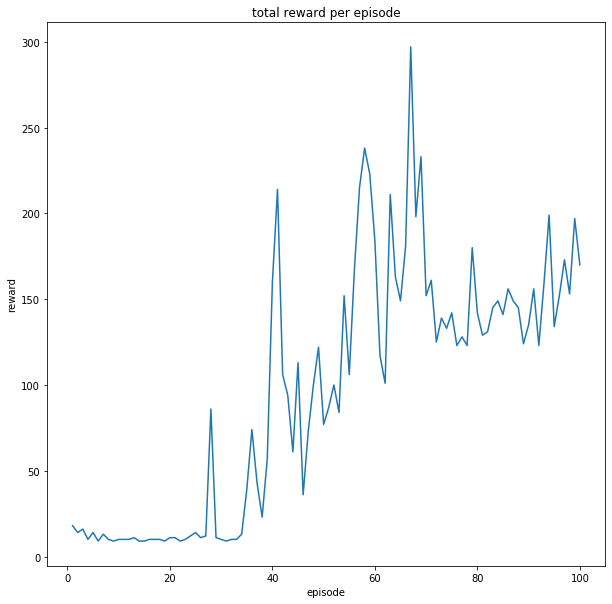

In [28]:



env = gym.make('CartPole-v1')
DQL=deep_Q_learning(episodes=100, max_memory_size=2000, discount=0.95, epsilon_start=1.0,epsilon_min=0.001,
        epsilon_decay=0.7,batch_size=20,state_size=env.observation_space.shape[0],
                 action_size=env.action_space.n)



def runDeepQLearning(env,DQL):
    for e in range(DQL.episodes):
        state = env.reset().reshape(1,4)
        done = False
        i = 0
        while not done:
            action=DQL.forward_step(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,4])
            DQL.add_to_memory(state, action, reward, next_state, done)
            state = next_state
            i += 1
            if DQL.get_memory_size() >= DQL.batch_size: 
                minibatch = random.sample(DQL.memory,DQL.batch_size)
                batch_state = np.zeros((DQL.batch_size, DQL.state_size))
                batch_next_state = np.zeros((DQL.batch_size, DQL.state_size))
                batch_action, batch_reward, batch_done = [], [], []
                for k in range(DQL.batch_size):
                    batch_state[k] = minibatch[k][0]
                    batch_action.append(minibatch[k][1])
                    batch_reward.append(minibatch[k][2])
                    batch_next_state[k] = minibatch[k][3]
                    batch_done.append(minibatch[k][4])

                target = DQL.predict(batch_state)
                target_next = DQL.predict(batch_next_state)

                for k in range(DQL.batch_size):
                    if batch_done[k]:
                        target[k][batch_action[k]] = batch_reward[k]
                    else:
                        target[k][batch_action[k]] = batch_reward[k] + DQL.discount * np.amax(target_next[k])

                DQL.fit(batch_state, target)

        DQL.add_episode_reward(i)
        DQL.decrease_epsilon()

        

runDeepQLearning(env,DQL)
DQL.plot_reward()
